In [1]:
import smbus
import time

class mpu6050:
    GRAVITIY_MS2 = 9.80665
    address = None
    bus = None

    ACCEL_SCALE_MODIFIER_2G = 16384.0
    ACCEL_SCALE_MODIFIER_4G = 8192.0
    ACCEL_SCALE_MODIFIER_8G = 4096.0
    ACCEL_SCALE_MODIFIER_16G = 2048.0

    GYRO_SCALE_MODIFIER_250DEG = 131.0
    GYRO_SCALE_MODIFIER_500DEG = 65.5
    GYRO_SCALE_MODIFIER_1000DEG = 32.8
    GYRO_SCALE_MODIFIER_2000DEG = 16.4

    ACCEL_RANGE_2G = 0x00
    ACCEL_RANGE_4G = 0x08
    ACCEL_RANGE_8G = 0x10
    ACCEL_RANGE_16G = 0x18

    GYRO_RANGE_250DEG = 0x00
    GYRO_RANGE_500DEG = 0x08
    GYRO_RANGE_1000DEG = 0x10
    GYRO_RANGE_2000DEG = 0x18

    FILTER_BW_256=0x00
    FILTER_BW_188=0x01
    FILTER_BW_98=0x02
    FILTER_BW_42=0x03
    FILTER_BW_20=0x04
    FILTER_BW_10=0x05
    FILTER_BW_5=0x06

    PWR_MGMT_1 = 0x6B
    PWR_MGMT_2 = 0x6C

    ACCEL_XOUT0 = 0x3B
    ACCEL_YOUT0 = 0x3D
    ACCEL_ZOUT0 = 0x3F

    TEMP_OUT0 = 0x41

    GYRO_XOUT0 = 0x43
    GYRO_YOUT0 = 0x45
    GYRO_ZOUT0 = 0x47

    ACCEL_CONFIG = 0x1C
    GYRO_CONFIG = 0x1B
    MPU_CONFIG = 0x1A

    def __init__(self, address, bus=1):
        self.address = address
        self.bus = smbus.SMBus(bus)
        self.bus.write_byte_data(self.address, self.PWR_MGMT_1, 0x00)

    def read_i2c_word(self, register):
        high = self.bus.read_byte_data(self.address, register)
        low = self.bus.read_byte_data(self.address, register + 1)
        value = (high << 8) + low
        return value - 65536 if value >= 0x8000 else value

    def get_temp(self):
        raw_temp = self.read_i2c_word(self.TEMP_OUT0)
        return (raw_temp / 340.0) + 36.53

    def read_accel_range(self, raw = False):
        raw_data = self.bus.read_byte_data(self.address, self.ACCEL_CONFIG)
        if raw: return raw_data
        return {self.ACCEL_RANGE_2G: 2, self.ACCEL_RANGE_4G: 4, self.ACCEL_RANGE_8G: 8, self.ACCEL_RANGE_16G: 16}.get(raw_data, -1)

    def get_accel_data(self, g = False):
        x = self.read_i2c_word(self.ACCEL_XOUT0)
        y = self.read_i2c_word(self.ACCEL_YOUT0)
        z = self.read_i2c_word(self.ACCEL_ZOUT0)
        accel_range = self.read_accel_range(True)
        modifier = {
            self.ACCEL_RANGE_2G: self.ACCEL_SCALE_MODIFIER_2G,
            self.ACCEL_RANGE_4G: self.ACCEL_SCALE_MODIFIER_4G,
            self.ACCEL_RANGE_8G: self.ACCEL_SCALE_MODIFIER_8G,
            self.ACCEL_RANGE_16G: self.ACCEL_SCALE_MODIFIER_16G,
        }.get(accel_range, self.ACCEL_SCALE_MODIFIER_2G)
        x, y, z = x/modifier, y/modifier, z/modifier
        if g:
            return {'x': x, 'y': y, 'z': z}
        else:
            return {'x': x*self.GRAVITIY_MS2, 'y': y*self.GRAVITIY_MS2, 'z': z*self.GRAVITIY_MS2}

    def read_gyro_range(self, raw = False):
        raw_data = self.bus.read_byte_data(self.address, self.GYRO_CONFIG)
        if raw: return raw_data
        return {self.GYRO_RANGE_250DEG: 250, self.GYRO_RANGE_500DEG: 500,
                self.GYRO_RANGE_1000DEG: 1000, self.GYRO_RANGE_2000DEG: 2000}.get(raw_data, -1)

    def get_gyro_data(self):
        x = self.read_i2c_word(self.GYRO_XOUT0)
        y = self.read_i2c_word(self.GYRO_YOUT0)
        z = self.read_i2c_word(self.GYRO_ZOUT0)
        gyro_range = self.read_gyro_range(True)
        modifier = {
            self.GYRO_RANGE_250DEG: self.GYRO_SCALE_MODIFIER_250DEG,
            self.GYRO_RANGE_500DEG: self.GYRO_SCALE_MODIFIER_500DEG,
            self.GYRO_RANGE_1000DEG: self.GYRO_SCALE_MODIFIER_1000DEG,
            self.GYRO_RANGE_2000DEG: self.GYRO_SCALE_MODIFIER_2000DEG,
        }.get(gyro_range, self.GYRO_SCALE_MODIFIER_250DEG)
        return {'x': x/modifier, 'y': y/modifier, 'z': z/modifier}

    def get_all_data(self):
        return {
            'temperature': self.get_temp(),
            'accel': self.get_accel_data(),
            'gyro': self.get_gyro_data()
        }


In [2]:
class Kalman1D:
#     xe chạy nhanh thì tên tinh chỉnh 
#     Q_angle = 0.002      # thấp hơn một chút để gyro mượt
#     Q_bias = 0.003
#     R_measure = 0.1 ~ 0.3   # tăng lên so với lúc đứng yên

    
    def __init__(self, Q_angle=0.5, Q_bias=0.01, R_measure=0.5):    # điều chỉnh giá trị  
        self.Q_angle = Q_angle
        self.Q_bias = Q_bias
        self.R_measure = R_measure

        self.angle = 0.0    
        self.bias = 0.0      
        self.rate = 0.0

        self.P = [[0, 0], [0, 0]]

    def get_angle(self, new_angle, new_rate, dt):
        self.rate = new_rate - self.bias
        self.angle += dt * self.rate

        self.P[0][0] += dt * (dt*self.P[1][1] - self.P[1][0] - self.P[0][1] + self.Q_angle)
        self.P[0][1] -= dt * self.P[1][1]
        self.P[1][0] -= dt * self.P[1][1]
        self.P[1][1] += self.Q_bias * dt

        S = self.P[0][0] + self.R_measure
        K = [self.P[0][0] / S, self.P[1][0] / S]

        y = new_angle - self.angle

        self.angle += K[0] * y
        self.bias  += K[1] * y

        P00_temp = self.P[0][0]
        P01_temp = self.P[0][1]

        self.P[0][0] -= K[0] * P00_temp
        self.P[0][1] -= K[0] * P01_temp
        self.P[1][0] -= K[1] * P00_temp
        self.P[1][1] -= K[1] * P01_temp

        return self.angle


In [ ]:
from jetracer.nvidia_racecar import NvidiaRacecar
car = NvidiaRacecar()

In [11]:
from math import atan2, sqrt, degrees, radians, cos, sin
import time, csv, os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from datetime import datetime

imu = mpu6050(address=0x68, bus=0)
kalman_pitch = Kalman1D(Q_angle=0.002, Q_bias=0.003, R_measure=0.2)
kalman_roll  = Kalman1D(Q_angle=0.002, Q_bias=0.003, R_measure=0.2)

x, y = 0.0, 0.0
vx, vy = 0.0, 0.0
yaw = 0.0

# Dữ liệu lưu để vẽ
x_data = []
y_data = []

def get_pitch(ax, ay, az):
    return degrees(atan2(ax, sqrt(ay**2 + az**2)))

def get_roll(ay, az):
    return degrees(atan2(ay, az))

filename = f"log_{datetime.now().strftime('%H%M%S')}.csv"
csv_file = open(filename, mode='w', newline='')
writer = csv.writer(csv_file)
writer.writerow(["time","x","y","pitch","roll","yaw"]) 

prev_time = time.time()
print(f"Đang chạy... lưu vào file: {filename}")

try:
    while True:
        now = time.time()
        dt = now - prev_time
        prev_time = now

        data = imu.get_all_data()
        ax = data['accel']['x'] / imu.GRAVITIY_MS2
        ay = data['accel']['y'] / imu.GRAVITIY_MS2
        az = data['accel']['z'] / imu.GRAVITIY_MS2

        gx = data['gyro']['x']
        gy = data['gyro']['y']
        gz = data['gyro']['z']

        pitch = kalman_pitch.get_angle(get_pitch(ax, ay, az), gx, dt)
        roll  = kalman_roll.get_angle(get_roll(ay, az), gy, dt)

        yaw += radians(gz) * dt

        ax_no_g = ax * imu.GRAVITIY_MS2
        ay_no_g = ay * imu.GRAVITIY_MS2

        vx += ax_no_g * dt
        vy += ay_no_g * dt
        x += vx * cos(yaw) - vy * sin(yaw)
        y += vx * sin(yaw) + vy * cos(yaw)

        x_data.append(x)
        y_data.append(y)
        writer.writerow([datetime.now().strftime("%H:%M:%S"), x, y, pitch, roll, degrees(yaw)])


        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        plt.plot(x_data, y_data, 'b.-')
        plt.xlabel("X (m)")
        plt.ylabel("Y (m)")
        plt.title("Quỹ đạo JetRacer (real-time)")
        plt.grid()
        plt.axis("equal")
        plt.show()

        # Nếu giảm xuống 0.02s (50Hz) hoặc 0.01s (100Hz) → dữ liệu dày hơn → đường vẽ mịn hơn.
        time.sleep(0.05) 

except KeyboardInterrupt:
    csv_file.close()
    print(f"Dừng chương trình. Dữ liệu đã lưu trong file {filename}")


Dừng chương trình. Dữ liệu đã lưu trong file log_023405.csv


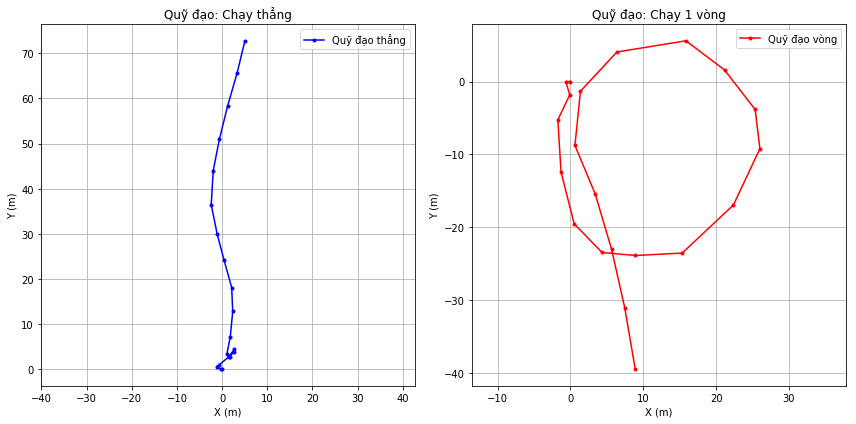

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


file1 = "log_015702.csv"  
file2 = "log_015457.csv"   

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)


fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].plot(df1['x'], df1['y'], 'b.-', label="Quỹ đạo thẳng")
axs[0].set_xlabel("X (m)")
axs[0].set_ylabel("Y (m)")
axs[0].set_title("Quỹ đạo: Chạy thẳng")
axs[0].axis("equal")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(df2['x'], df2['y'], 'r.-', label="Quỹ đạo vòng")
axs[1].set_xlabel("X (m)")
axs[1].set_ylabel("Y (m)")
axs[1].set_title("Quỹ đạo: Chạy 1 vòng")
axs[1].axis("equal")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()
